In [29]:
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import numpy as np
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix
from sklearn.linear_model import Lasso
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso, LassoCV
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# Have some time series data (via pandas)
df = pd.read_csv('dataset03.csv')
df_test=pd.read_csv('dataset02.csv')


In [3]:
print(df.shape)
print(df_test.shape)

(6324, 66)
(984, 66)


Hay que justificar esto

In [4]:
idx=0
for i in range(len(df)):
    idx+=1
    if idx>(len(df)-288):
        df.iloc[i]['y2']=1


In [5]:
idx=0
for i in range(len(df_test)):
    idx+=1
    if idx>(len(df_test)-288):
        df_test.iloc[i]['y0']=1

In [6]:
print(df['y2'].value_counts())
print(df_test['y0'].value_counts())

0.0    6036
1.0     288
Name: y2, dtype: int64
0.0    696
1.0    288
Name: y0, dtype: int64


In [7]:
df.columns.values

array(['aMean_0', 'std_0', 'irq_0', 'skew_0', 'kurtosis_0', 'f0_0',
       'Pf0_0', 'Xrms_0', 'zeroX_0', 'p2p_0', 'crest_0', 'clearance_0',
       'shape_0', 'impulse_0', 'aMean_1', 'std_1', 'irq_1', 'skew_1',
       'kurtosis_1', 'f0_1', 'Pf0_1', 'Xrms_1', 'zeroX_1', 'p2p_1',
       'crest_1', 'clearance_1', 'shape_1', 'impulse_1', 'aMean_2',
       'std_2', 'irq_2', 'skew_2', 'kurtosis_2', 'f0_2', 'Pf0_2',
       'Xrms_2', 'zeroX_2', 'p2p_2', 'crest_2', 'clearance_2', 'shape_2',
       'impulse_2', 'aMean_3', 'std_3', 'irq_3', 'skew_3', 'kurtosis_3',
       'f0_3', 'Pf0_3', 'Xrms_3', 'zeroX_3', 'p2p_3', 'crest_3',
       'clearance_3', 'shape_3', 'impulse_3', 'covar_01', 'covar_02',
       'covar_03', 'covar_12', 'covar_13', 'covar_23', 'y0', 'y1', 'y2',
       'y3'], dtype=object)

Creamos dos nuevos dataframes para hacer predicciones sobre el rodamiento del cual tenemos la informacion que fue el primero en fallar, en este caso para un conjunto de datos fallo b2 (usado para train) y para el otro b0 (usado para test)

In [16]:
new_features2=['irq_2', 'skew_2', 'kurtosis_2', 'f0_2',
       'Pf0_2', 'Xrms_2', 'zeroX_2', 'p2p_2', 'crest_2', 'clearance_2','shape_2']#media,desvio e impulso no lo incluimos por lo de la otra note

In [17]:
new_features0=['irq_0', 'skew_0', 'kurtosis_0', 'f0_0',
       'Pf0_0', 'Xrms_0', 'zeroX_0', 'p2p_0', 'crest_0', 'clearance_0','shape_0'] 


In [18]:
df2=df[new_features2]
df0=df_test[new_features0]


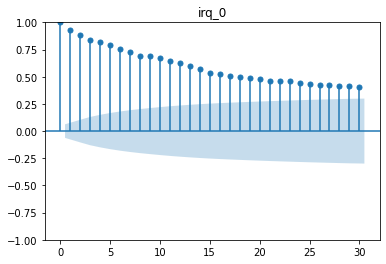

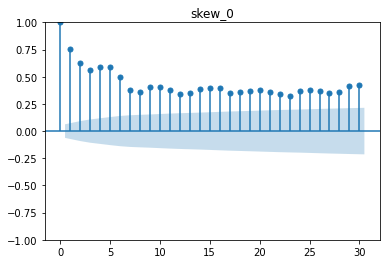

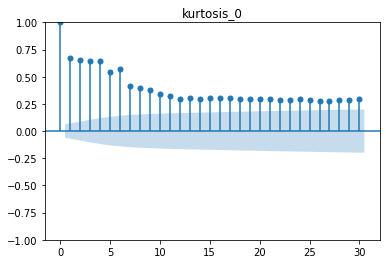

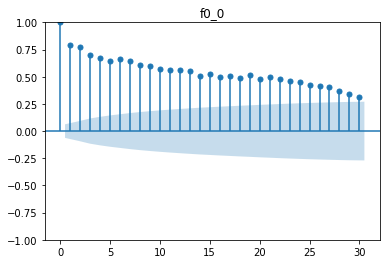

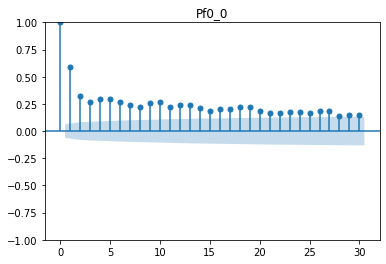

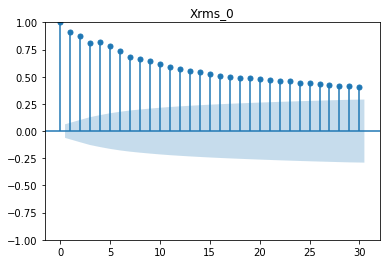

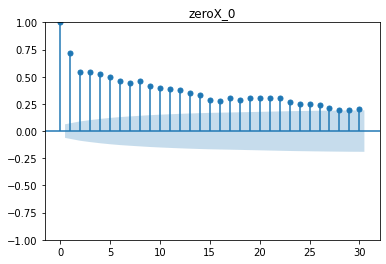

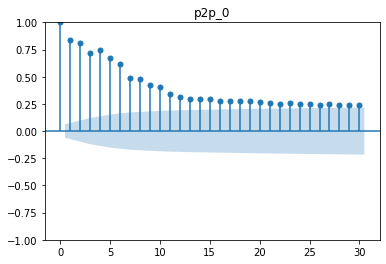

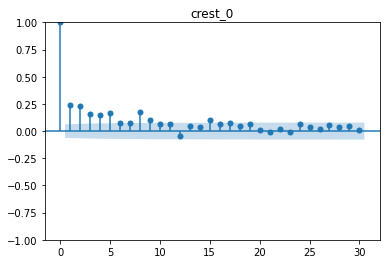

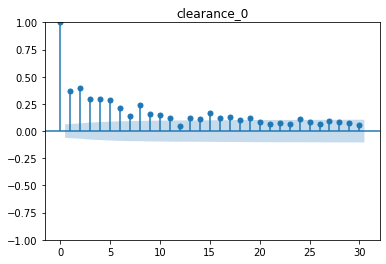

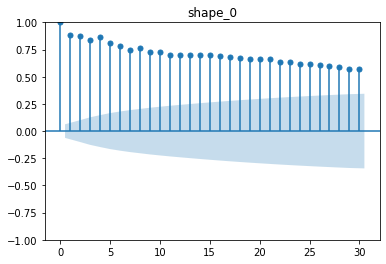

In [19]:
for i in df0.columns:
    #acf_plot=plot_acf(df2[i])
    #print(i)
    plot_acf(df0[i],alpha=0.05,title=i)

In [16]:

#con los graficos de autocorrelacion podemos tb sacar features y luego usar shift solo para las que tienen importancia en el historial ? 
#con esto podemos eliminar crest y clearance antes de hacer el desplazamiento? 

Transformacion del dataset

In [20]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
 


In [21]:

df_tr0 = series_to_supervised(df0, 5)
df_tr2 = series_to_supervised(df2, 5)


In [22]:
print(df2.shape)
print(df_tr2.shape)

(6324, 11)
(6319, 66)


In [23]:
target0=df_test['y0']
target2=df['y2']
df_tr0['y0']=target0
df_tr2['y2']=target2
df_tr0.head()

,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var7(t-5),var8(t-5),var9(t-5),var10(t-5),...,var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),y2
5,0.086,0.083455,0.592253,984.375000,45.123977,0.066390,7990.0,0.671,5.437565,8.308677,...,0.424142,986.328125,47.667749,0.069830,7657.0,0.727,5.484716,8.296254,1.269187,0.0
6,0.086,0.011829,0.360079,985.351562,45.995787,0.066285,8024.0,0.590,4.450449,6.732732,...,0.666801,986.328125,46.023281,0.069499,7870.0,0.986,8.705145,13.246652,1.274221,0.0
7,0.093,0.049060,0.214038,231.445312,47.827940,0.069186,7895.0,0.572,4.133782,6.199789,...,0.431156,986.328125,48.499259,0.067030,8055.0,0.713,5.355775,8.096179,1.268272,0.0
8,0.093,0.002209,0.299358,231.445312,45.885568,0.068637,7831.0,0.659,5.084751,7.649020,...,0.338973,986.328125,48.897636,0.070065,7644.0,0.654,5.052455,7.599394,1.265702,0.0
9,0.088,0.031886,0.396086,986.328125,45.616624,0.067469,7928.0,0.762,5.750781,8.680947,...,0.331245,231.445312,48.449678,0.069366,7599.0,0.759,5.175468,7.818382,1.267938,0.0


In [ ]:
# Save to CSV
PATH_DATASET = "./datasetTEST.csv"
df_tr0.to_csv(PATH_DATASET, index=False)

In [ ]:
PATH_DATASET = "./datasetTRAIN.csv"
df_tr2.to_csv(PATH_DATASET, index=False)

Hasta aca transformacion del dataset. 

In [27]:
x_2=df_tr2.iloc[:,:-1]
y_2=df_tr2.iloc[:,-1]

<AxesSubplot:ylabel='y2'>

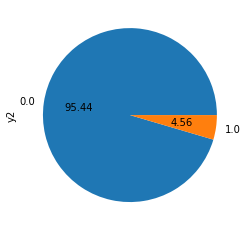

In [28]:
y_2.value_counts().plot.pie(autopct='%.2f')

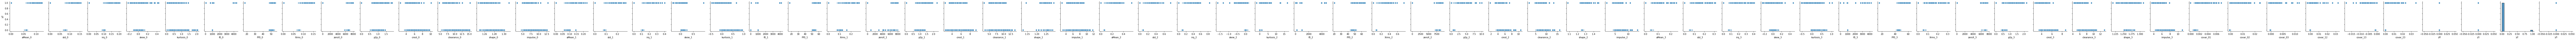

In [30]:
sns.pairplot(df_, y_vars="y0", x_vars=df_new.columns.values)

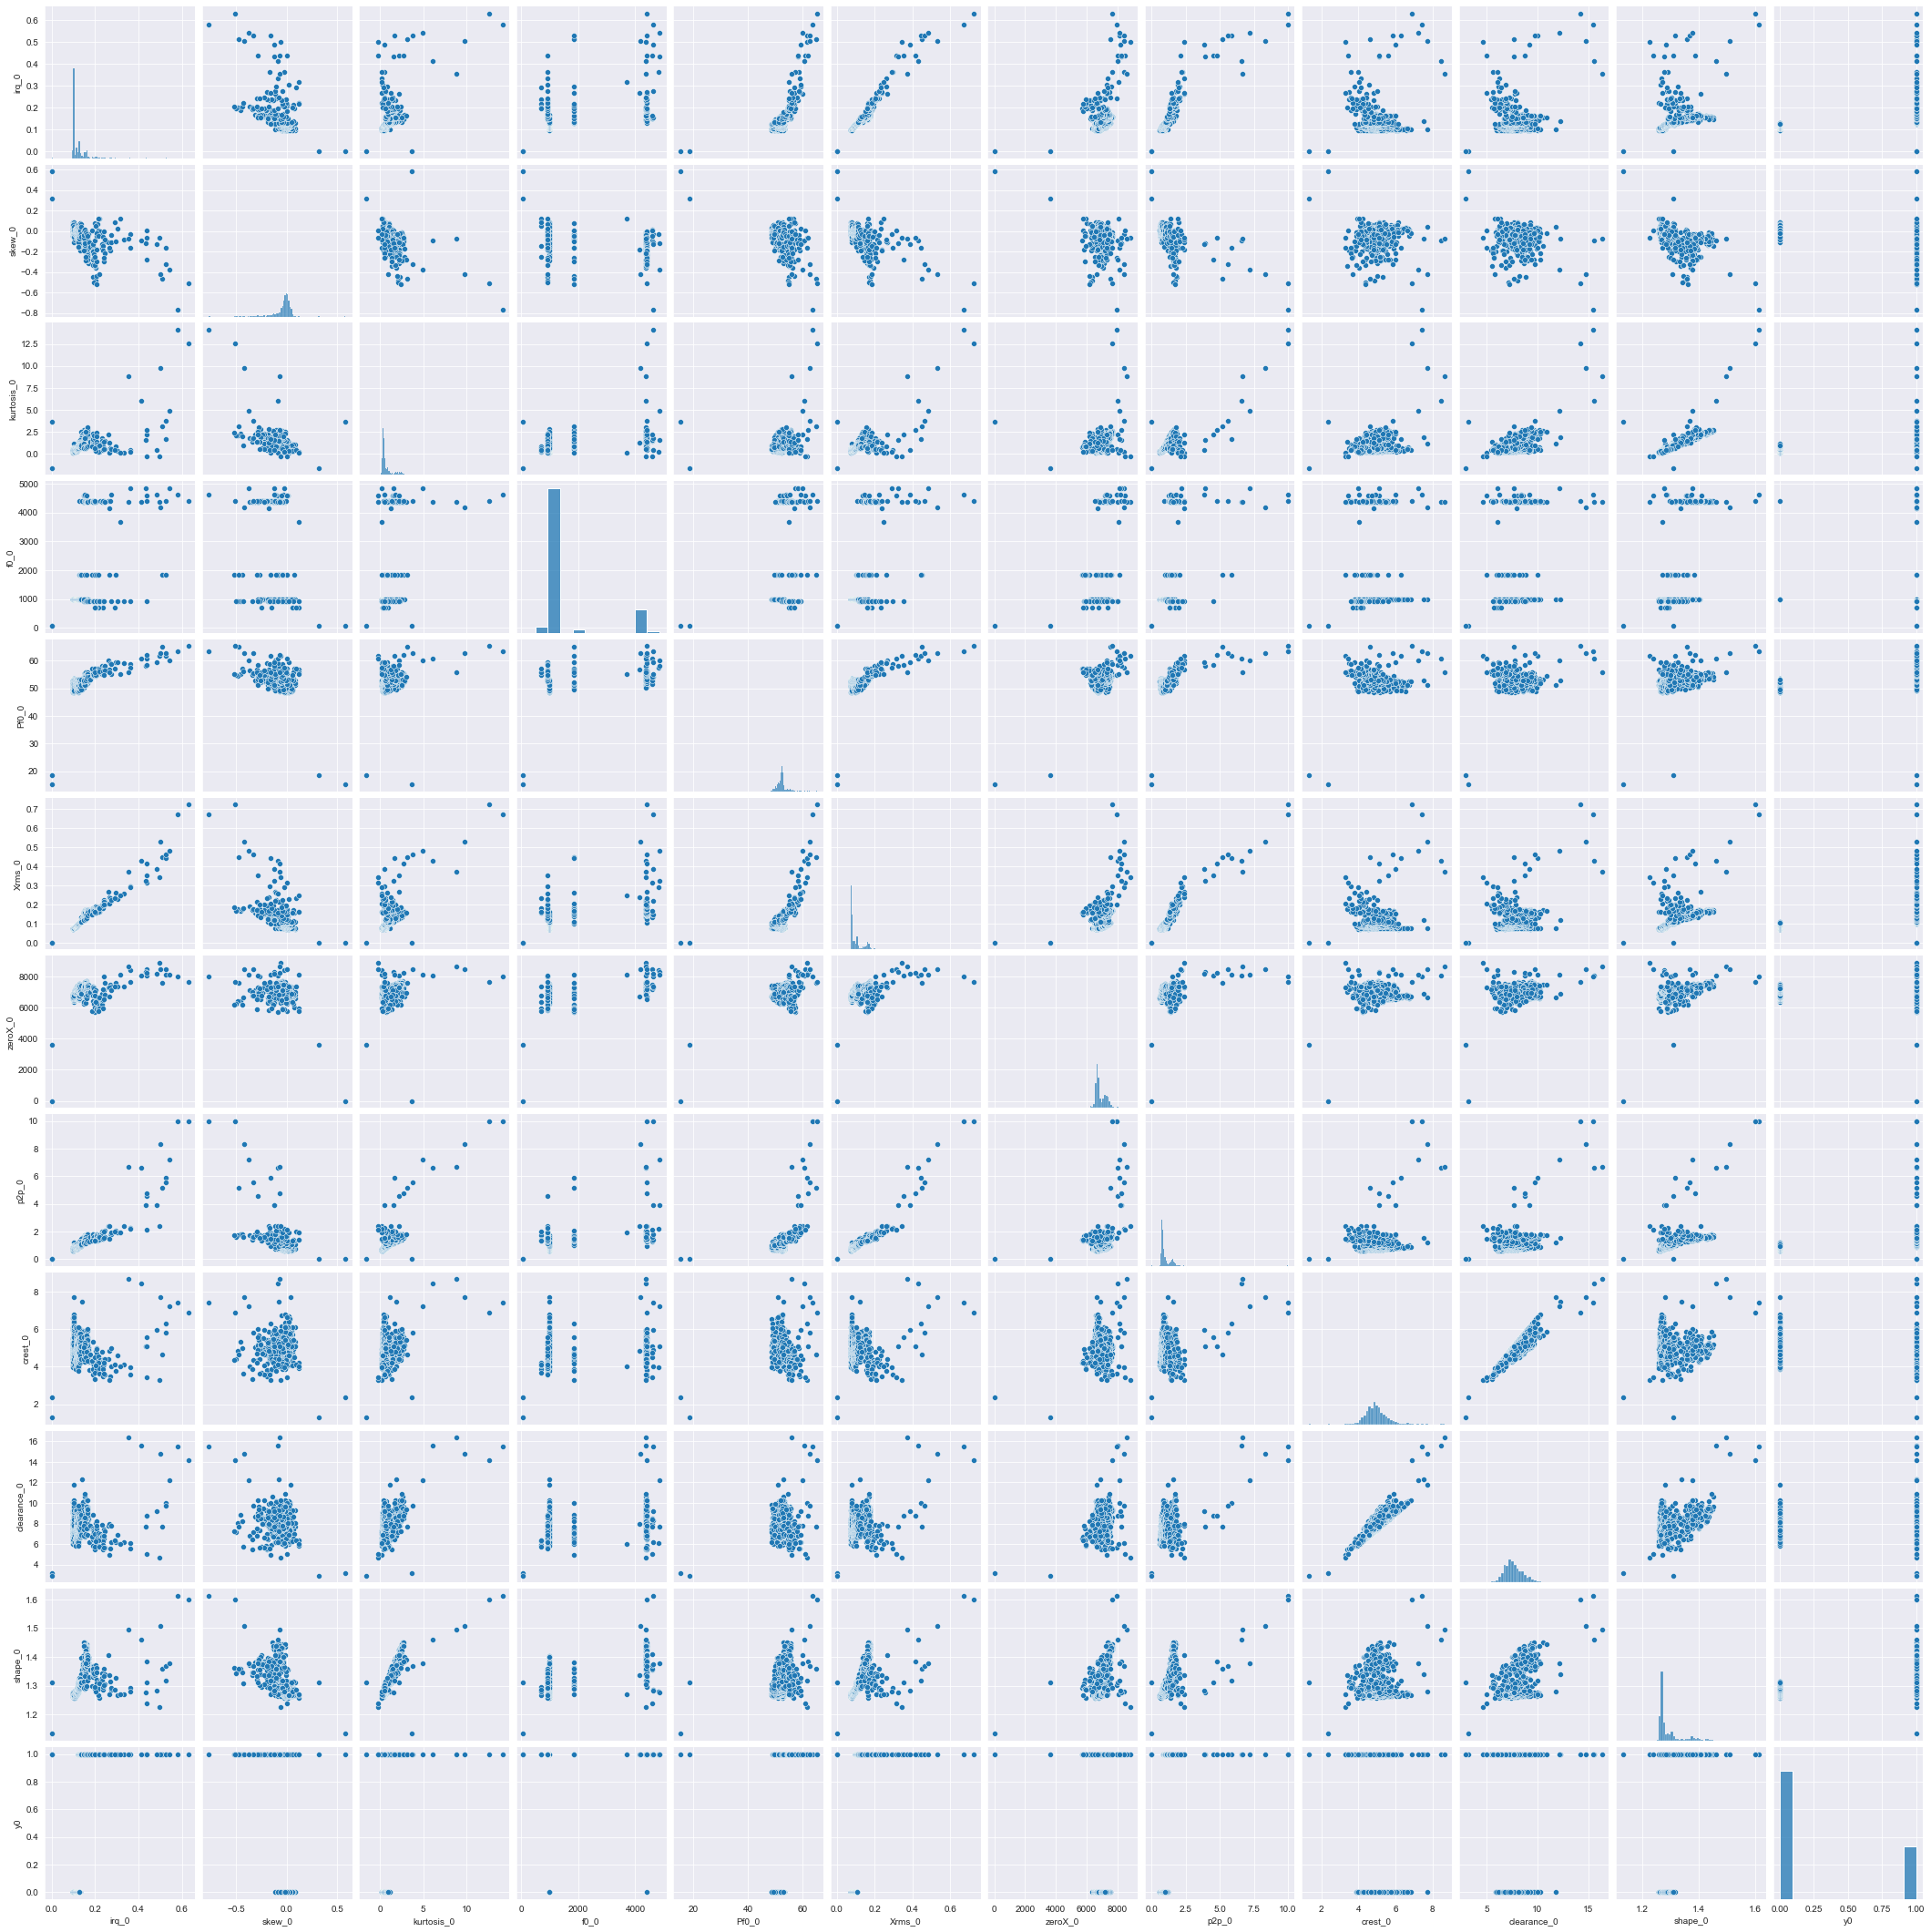

In [51]:
sns.set_style('darkgrid')
sns.pairplot(df_new)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(x_, y_, test_size=0.2, random_state=10)# aca es necesario mezclar los datos verdad¡? 

In [40]:
X_train.head()

,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var7(t-5),var8(t-5),var9(t-5),var10(t-5),...,var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t)
354,0.103,0.030254,0.306155,985.351562,52.543499,0.076681,6779.0,0.788,5.346815,7.999418,...,-0.023116,0.520991,985.351562,52.058062,0.077874,6719.0,0.810,4.635691,7.037439,1.273360
17,0.103,0.025770,0.364726,985.351562,52.599606,0.077405,6646.0,0.778,5.167653,7.781061,...,0.020391,0.447749,986.328125,51.737839,0.077623,6485.0,0.849,5.217541,7.863946,1.267425
590,0.117,0.017609,0.514671,985.351562,52.264978,0.089729,7199.0,0.908,5.628067,8.553539,...,-0.030888,0.543121,985.351562,51.227236,0.090869,7226.0,0.869,4.567021,7.005750,1.281722
310,0.100,-0.013293,0.398123,985.351562,49.750817,0.077038,6671.0,0.749,5.477834,8.276784,...,-0.034632,0.462615,985.351562,51.012869,0.078246,6798.0,0.794,4.933190,7.463963,1.270727
724,0.156,-0.095620,2.370612,4386.718750,54.634680,0.168101,7570.0,1.499,4.515131,8.206806,...,-0.127545,2.624171,4372.070312,55.589155,0.163216,7448.0,1.553,4.711551,8.647291,1.436730
